### Method of the Notebok

In this workflow, we aimed to assess scale dependence across different bands in our dataset using nonparametric, **median-based** statistical methods $-$ following practices outlined in **Wilks (2019) _Statistical Methods in the Atmospheric Sciences (4th edition)_**. 

First verify the distribution assumption before deciding which staitistical test to apply. Checks for **normality** on each band using the Shapiro–Wilk test (basically asking: "Does this data follow a bell curve?"). For visual exploration, it also generates **Q–Q plots**. 

Because many of our data distributions exhibit outliers and heavy tails, we opt for nonparametric approaches. For example, we adopt the Mann–Whitney U test in place of a classical t-test (basically asking: "If I randomly select a value from band0 and a value from band1, what's the probability the band0 value is larger?"). Rather than directly comparing means (which can be heavily influenced by outliers), Mann–Whitney compares the entire distributions to detect if one tends to contain larger values than the other—making it much more robust when dealing with skewed data like ours. Similarly, we employ Mood's median test to specifically examine differences in central tendency (basically asking: "Is the median of band0 different from the median of band1?"). This test works by counting how many observations in each group fall above or below the combined median, making it particularly effective when distributions differ in shape but we still want to compare their centers.

Wilks (2019) also describes the importance of bootstrap methods for estimating confidence intervals in the face of nonnormal data. Hence, we define a `bootstrap_confidence_intervals` function that resamples (with replacement) our array multiple times to compute empirical confidence bounds for robust statistics: the median, interquartile range (IQR), and skewness (basically asking: "If we had collected many different samples, what range would likely contain the true median?"). This approach gives us a distribution-free view of parameter uncertainty, and all bootstrap confidence intervals were computed at a **99% confidence level** to ensure rigorous uncertainty quantification.

After these individual checks, we carry out an **omnibus test** (the Kruskal–Wallis H-test) across all bands at once (basically asking: "Is there any difference at all among these three bands?"). If this indicates significant group differences, we proceed with **pairwise** Mann–Whitney tests (basically asking: "Which specific pairs of bands differ from each other?"), plus p-value adjustments for multiple comparisons. Additionally, a **Kolmogorov–Smirnov (K–S) test** checks overall distributional differences beyond just location or scale (basically asking: "Do these two bands follow completely different distributions?"). Finally, we produce a variety of visualizations, including boxplots, violin plots, and ratio plots, to illustrate distribution shapes and how each band relates to the others.

### Results

The band ratios (Band0/Band1 = $\approx 500$ and Band1/Band2= $\approx 2$) provide direct evidence of scale dependence of the power $(\text{FFT}(\sigma(\bf{x})))^2$ in our data, showing how the power drops as we move from larger to smaller scales. 

Across all pairwise comparisons, the p-values are essentially zero, strongly indicating that the differences in power levels between bands are statistically significant. The Kolmogorov-Smirnov (K-S) test further confirmed that the distributions differ beyond just location shifts, reinforcing that the scale dependence is not merely a shift in central tendency but a more fundamental change in distributional properties.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind, levene, ks_2samp, shapiro, bartlett, f_oneway, kruskal
from statsmodels.stats.multitest import multipletests
from utils.functions import *

Length of dfs before any filtering: df_wv1 = 36925, df_wv2 = 37000.
Length of dfs after filtering on 0 < mean_sigma0 < 1: 36868, 36949.
Length of dfs after filtering on 0 < mean_psd_band0 < 1e6: 35857, 36949.
Length of dfs after filtering on 0 < mean_psd_band1 < 4000: 33638, 36941.
Length of dfs after filtering on 0 < mean_psd_band2 < 2000: 30187, 36941.


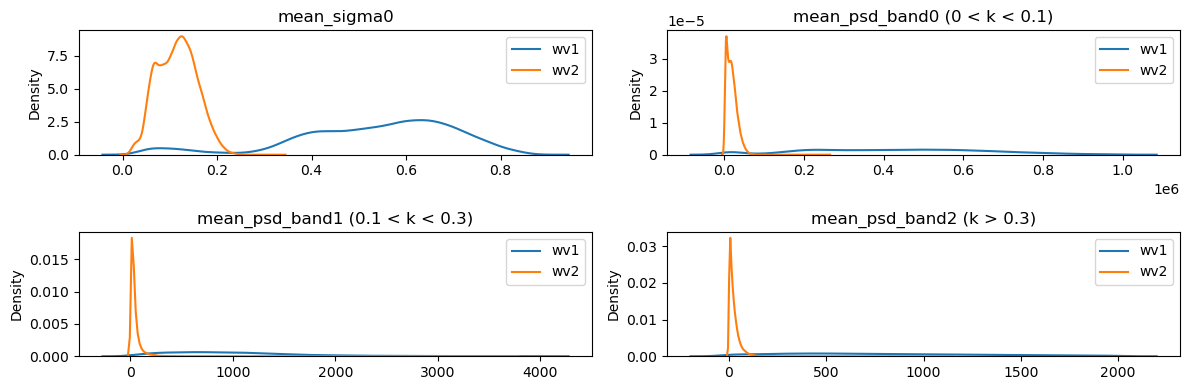

In [2]:
# read parquet

df_wv1 = pd.read_parquet('processed_data/wv1_unstable_gt15.parquet')
df_wv2 = pd.read_parquet('processed_data/wv2_unstable_gt15.parquet')

print(f"Length of dfs before any filtering: df_wv1 = {len(df_wv1)}, df_wv2 = {len(df_wv2)}.")

# Filter data
df_wv1 = df_wv1[(df_wv1.mean_sigma0 > 0) & (df_wv1.mean_sigma0 < 1)]
df_wv2 = df_wv2[(df_wv2.mean_sigma0 > 0) & (df_wv2.mean_sigma0 < 1)]

print(f"Length of dfs after filtering on 0 < mean_sigma0 < 1: {len(df_wv1)}, {len(df_wv2)}.")

df_wv1 = df_wv1[(df_wv1.mean_psd_band0 > 0) & (df_wv1.mean_psd_band0 < 1e6)]
df_wv2 = df_wv2[(df_wv2.mean_psd_band0 > 0) & (df_wv2.mean_psd_band0 < 1e6)]

print(f"Length of dfs after filtering on 0 < mean_psd_band0 < 1e6: {len(df_wv1)}, {len(df_wv2)}.")

df_wv1 = df_wv1[(df_wv1.mean_psd_band1 > 0) & (df_wv1.mean_psd_band1 < 4000)]
df_wv2 = df_wv2[(df_wv2.mean_psd_band1 > 0) & (df_wv2.mean_psd_band1 < 4000)]

print(f"Length of dfs after filtering on 0 < mean_psd_band1 < 4000: {len(df_wv1)}, {len(df_wv2)}.")

df_wv1 = df_wv1[(df_wv1.mean_psd_band2 > 0) & (df_wv1.mean_psd_band2 < 2000)]
df_wv2 = df_wv2[(df_wv2.mean_psd_band2 > 0) & (df_wv2.mean_psd_band2 < 2000)]

print(f"Length of dfs after filtering on 0 < mean_psd_band2 < 2000: {len(df_wv1)}, {len(df_wv2)}.")

# Create figure and subplots
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 4))

# First subplot - mean_sigma0
sns.kdeplot(data=df_wv1.mean_sigma0.values, label="wv1", ax=ax1)
sns.kdeplot(data=df_wv2.mean_sigma0.values, label="wv2", ax=ax1)
ax1.set_title('mean_sigma0')
ax1.legend()

# Second subplot - mean_psd_band0
sns.kdeplot(data=df_wv1.mean_psd_band0.values, label="wv1", ax=ax2)
sns.kdeplot(data=df_wv2.mean_psd_band0.values, label="wv2", ax=ax2)
ax2.set_title('mean_psd_band0 (0 < k < 0.1)')
ax2.legend()

# Third subplot - mean_psd_band1
sns.kdeplot(data=df_wv1.mean_psd_band1.values, label="wv1", ax=ax3)
sns.kdeplot(data=df_wv2.mean_psd_band1.values, label="wv2", ax=ax3)
ax3.set_title('mean_psd_band1 (0.1 < k < 0.3)')
ax3.legend()

# Fourth subplot - mean_psd_band2
sns.kdeplot(data=df_wv1.mean_psd_band2.values, label="wv1", ax=ax4)
sns.kdeplot(data=df_wv2.mean_psd_band2.values, label="wv2", ax=ax4)
ax4.set_title('mean_psd_band2 (k > 0.3)')
ax4.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

Performing comprehensive scale dependence analysis using median-based methods...

Checking normality of distributions...


c:\Users\GuilhermeAlvarenga\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30187.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\GuilhermeAlvarenga\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 36941.
  res = hypotest_fun_out(*samples, **kwds)



Computing bootstrap confidence intervals for medians...

Performing omnibus tests across all bands...
  WV1 - Kruskal-Wallis H-test: p-value = 0.000000 (SIGNIFICANT)
  WV2 - Kruskal-Wallis H-test: p-value = 0.000000 (SIGNIFICANT)

Performing pairwise comparisons between bands...

Generating visualizations...


c:\Users\GuilhermeAlvarenga\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30187.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\GuilhermeAlvarenga\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30187.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\GuilhermeAlvarenga\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30187.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\GuilhermeAlvarenga\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 36941.
  res =


Creating summary tables...


,Comparison,Dataset,Normality,Location Test,Location p-value,Adjusted p-value,Scale Test p-value,KS Test p-value,Scale Dependent?
0,All bands,WV1,Not all normal,Kruskal-Wallis H-test,0.000000e+00,N/A,N/A,N/A,Yes
1,mean_psd_band0 vs mean_psd_band1,WV1,Non-normal,Mann-Whitney U test,0.000000e+00,0.0,0.0,0.0,Yes
2,mean_psd_band1 vs mean_psd_band2,WV1,Non-normal,Mann-Whitney U test,2.146894e-294,0.0,0.0,0.0,Yes
3,mean_psd_band0 vs mean_psd_band2,WV1,Non-normal,Mann-Whitney U test,0.000000e+00,0.0,0.0,0.0,Yes
4,All bands,WV2,Not all normal,Kruskal-Wallis H-test,0.000000e+00,N/A,N/A,N/A,Yes
5,mean_psd_band0 vs mean_psd_band1,WV2,Non-normal,Mann-Whitney U test,0.000000e+00,0.0,0.0,0.0,Yes
6,mean_psd_band1 vs mean_psd_band2,WV2,Non-normal,Mann-Whitney U test,0.000000e+00,0.0,0.0,0.0,Yes
7,mean_psd_band0 vs mean_psd_band2,WV2,Non-normal,Mann-Whitney U test,0.000000e+00,0.0,0.0,0.0,Yes


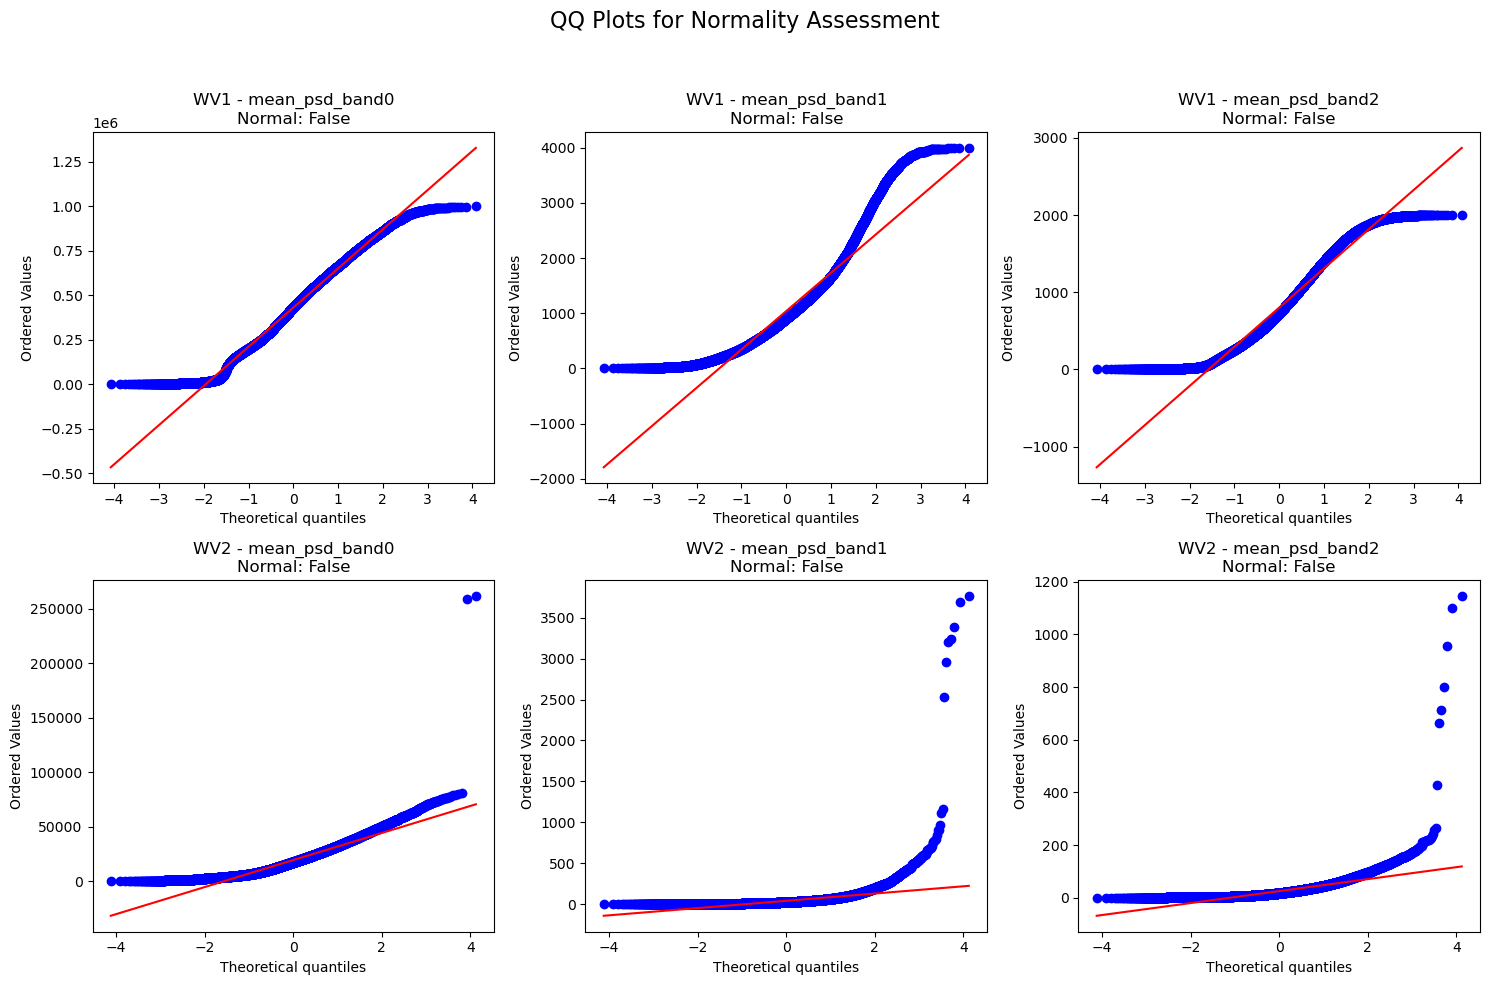

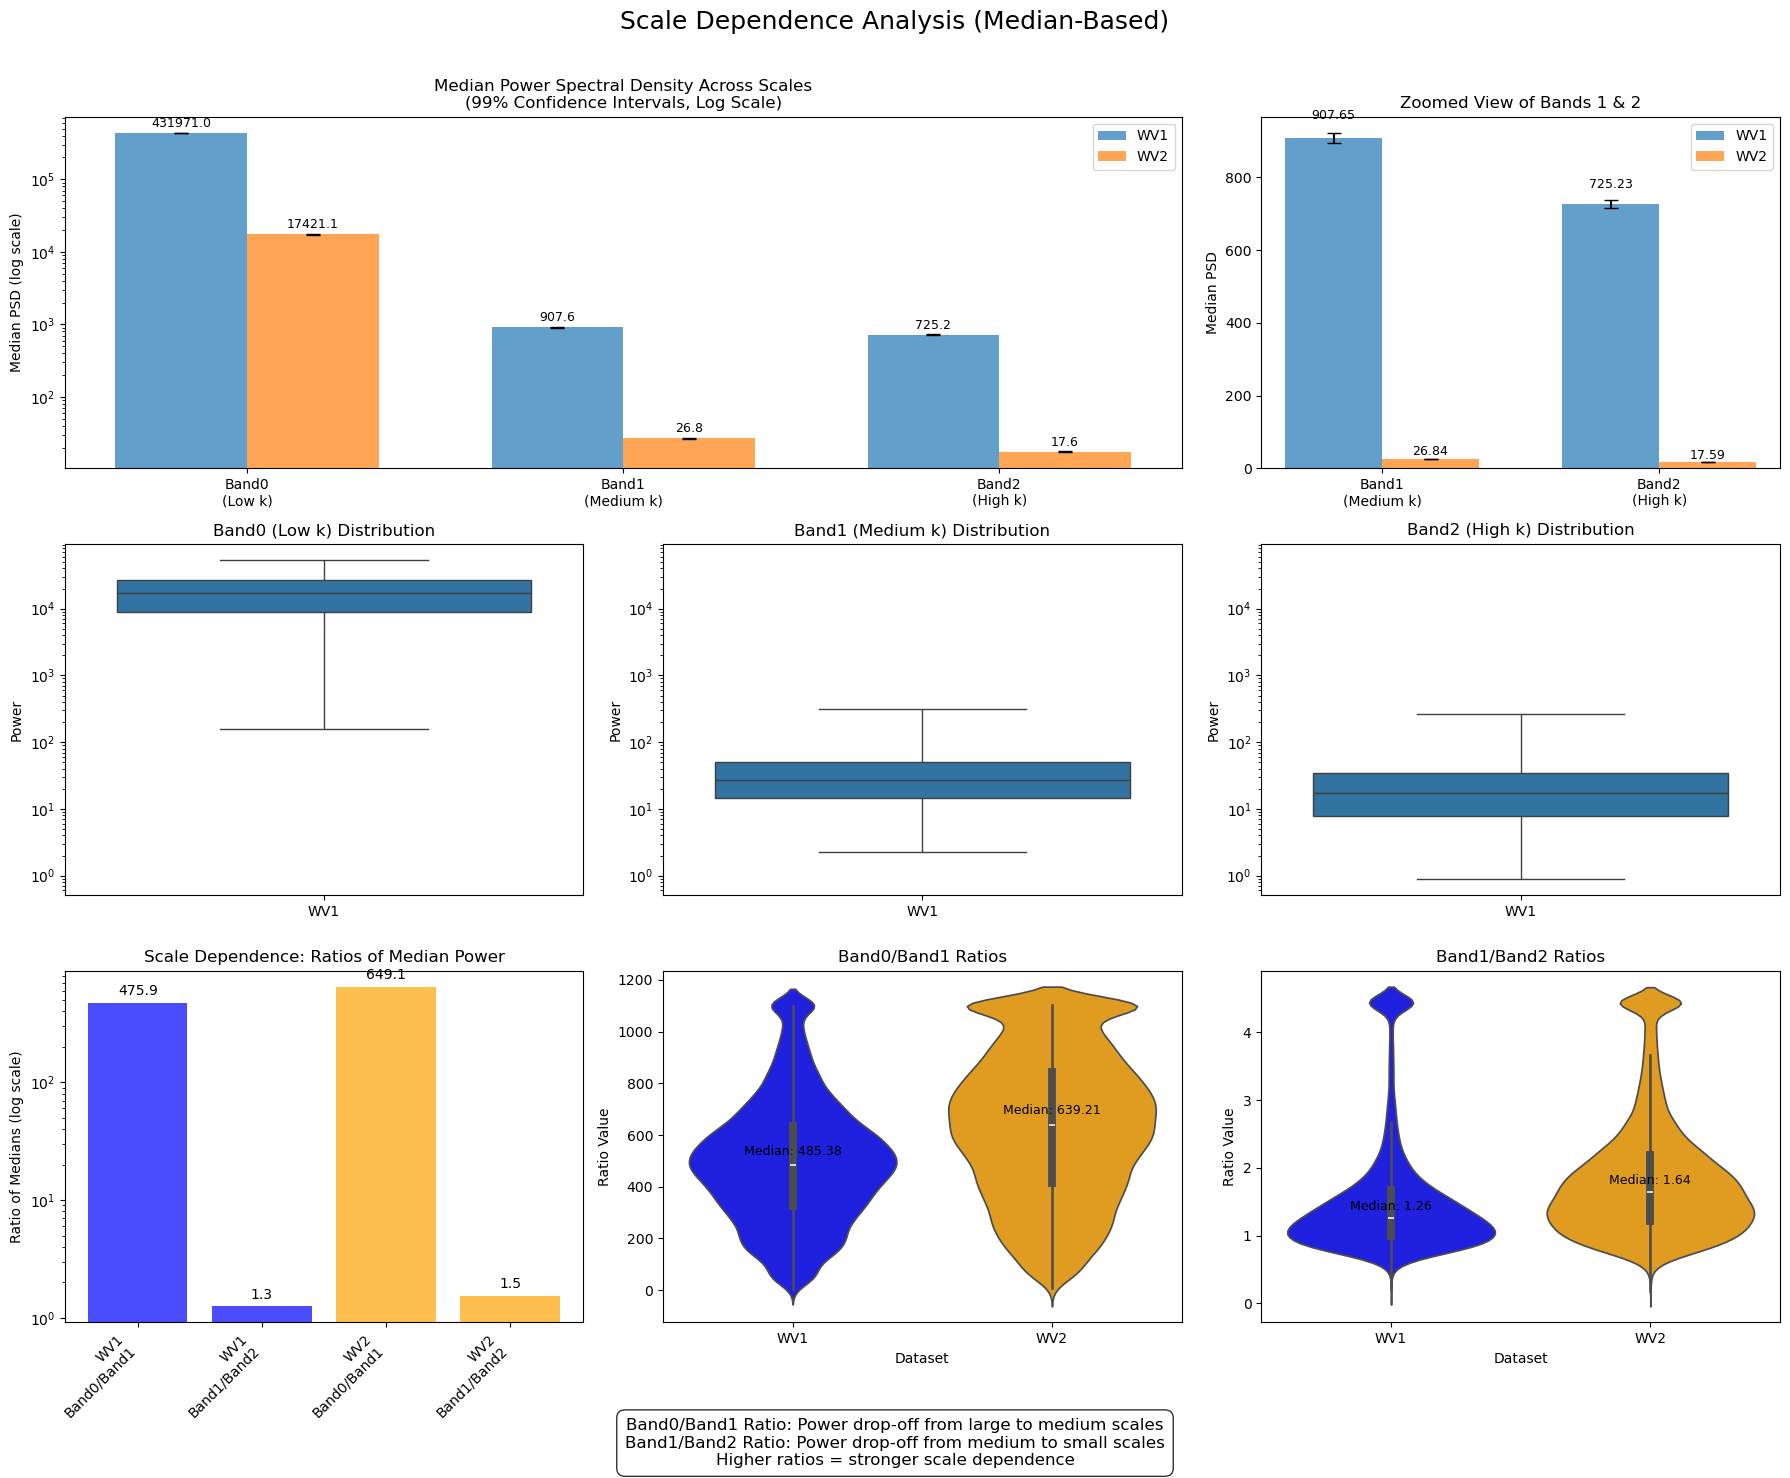

In [3]:
results, summary = analyze_scale_dependence(df_wv1, df_wv2, bootstrap_samples=1000, confidence=0.99)
summary